In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torchvision.utils as utils
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
#datasets와 transforms 쓰는 이유 -> 기존입력 : 28*28 (0~255), gan입력 : 분포를 바탕으로 이미지 구성해야됨

from matplotlib import pyplot as plt

################################
#      Discriminator 설계      #
################################

class MNIST_Discriminator(nn.Module):

  def __init__(self, config):
    super(MNIST_Discriminator, self).__init__()

    # 입력층 노드 수
    self.inode = config["d_input_node"]
    #크기 : 28*28

    # 은닉층 노드 수
    self.hnode = config["d_hidden_node"]
    # 출력층 노드 수: 분류해야 하는 레이블 수
    self.onode = config["d_output_node"]
    #real / fake (0 or 1)

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             #generator의 output을 tanh를 사용함 -> LeakyReLU사용
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Sigmoid()) #0부터 1사이의 값으로 출력
    
  def forward(self, input_features):
    hypothesis = self.net(input_features)
    return hypothesis

################################
#        Generator 설계        #
################################

class MNIST_Generator(nn.Module):

  def __init__(self, config):
    super(MNIST_Generator, self).__init__()

    # 입력층 노드 수
    self.inode = config["g_input_node"]
    #g의 size : 28*28보다 작음(작은거에서 noise생성)
    # 은닉층 노드 수
    self.hnode = config["g_hidden_node"]
    # 출력층 노드 수: 생성해야 하는 노드 수
    self.onode = config["g_output_node"]
    #28*28

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True), #28*28
                             nn.Tanh()) #-1 ~ 1

  def forward(self, input_features):
    hypothesis = self.net(input_features)
    #input_features = z
    #hypothesis = 28*28
    return hypothesis

In [3]:
def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2 
    #img가 -1부터 1사이의 값을 가짐(nomalize를 하고 마지막 tanh)
    #0부터 1사이의 값이 찍히도록 하도록
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    #28*28을 가로 28,세로28로 바꿈(1-dim -> 2-dim)
    plt.show()

In [4]:
# 데이터 읽기 함수
def load_dataset():
  standardizator = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])
  '''
  평균 : 0.5, 표준편차 : 0.5
  초기 Gan의 문제점 : 입력 데이터를 잘 전처리해주지않으면 학습이 잘 되지 않는다
  ->잘 만들어진 데이터를 가져다씀
  ->분포를 예측하는 것이다.(분포를 generate)
  '''
  # MNIST dataset
  train_X = datasets.MNIST(root='/gdrive/My Drive/colab/gan/mnist/data/', train=True, transform=standardizator, download=True)    
  return train_X
  #test셋은 생성하기 때문에 필요없다.

In [5]:
def get_noise(batch_size=16, g_input_node=100): #g_input_node -> 28*28보다 작아야됨
    return torch.randn(batch_size, g_input_node)
    #randn N(0,1)에 맞추어 생성

def do_test(model, input_node):
  # 평가 모드 셋팅
  model.eval()

  with torch.no_grad():

    X = get_noise(g_input_node=input_node).cuda() #z크기만큼
    hypothesis = model(X) #hypothesis = 28*28
    hypothesis_ = hypothesis.reshape((-1,28,28)).unsqueeze(1) #2차원 형태로 변경#unsqueeze(1) : 28*28 격자 형태로 맞춰줌
    imshow_grid(hypothesis_)  

In [8]:
# 모델 학습 함수
def train(config):

  # Discriminator와 Generator 모델 생성
  # 이곳을 채우세요.
  D = MNIST_Discriminator(config).cuda()
  G = MNIST_Generator(config).cuda()

  # 데이터 읽기
  input_features = load_dataset() #real_image
  
  # DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
  train_dataloader = DataLoader(input_features, shuffle=True, batch_size=config["batch_size"])

  # 바이너리 크로스엔트로피 비용 함수 
  loss_func = nn.BCELoss() #D를 위한 (real or fake)

  # Discriminator와 Generator 옵티마이저 함수 지정
  # 이곳을 채우세요.
  D_optimizer = torch.optim.Adam(D.parameters(), lr=config["learn_rate"])
  G_optimizer = torch.optim.Adam(G.parameters(), lr=config["learn_rate"])

  for epoch in range(config["epoch"]+1):

    # Discriminator와 Generator 학습 모드 셋팅
    #특정 epoch마다 evaluation모드로 변경해서 generator가 생성한 그림 보여줌
    D.train()
    G.train()
    
    # epoch 마다 평균 비용을 저장하기 위한 리스트
    D_costs, G_costs = [], []

    for (step, batch) in enumerate(train_dataloader):

      # batch = (input_features[step], labels[step])*batch_size
      # .cuda()를 통해 메모리에 업로드
      batch = tuple(t.cuda() for t in batch)

      # 배치 크기 만큼 입력 데이터 읽기 
      input_features, _ = batch #_는 label
      input_features = input_features.view(-1,config['d_input_node']) #-1은 행(batch : 모든것을 뜻 함) ,config['d_input_node']의 28*28을 1차원으로 바꿔줌
      
      ################################
      #      Discriminator 학습      #
      ################################

      # 역전파 변화도 초기화
      D_optimizer.zero_grad()
 
      # 진짜에 대한 비용 계산
      real_hypothesis = D(input_features) #real = 1
      real_labels = Variable(torch.ones(config["batch_size"],1)).cuda() #1을 batchsize만큼 만든다
      real_cost = loss_func(real_hypothesis, real_labels)
      
      # 가짜에 대한 비용 계산
      # 가짜 (generator의 출력을 discriminator의 입력으로)
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda() #noise생성
      fake_hypothesis = D(G(fake_input_features)) #fake_input_features = z
      fake_labels = Variable(torch.zeros(config["batch_size"],1)).cuda()
      # 이곳을 채우세요.
      fake_cost = loss_func(fake_hypothesis, fake_labels)
      #

      # 전체 비용 역전파 수행
      # 이곳을 채우세요.
      total_cost = real_cost + fake_cost
      #
      total_cost.backward()
      D_optimizer.step()

      # 현재 batch의 스텝 별 Discrimnator 비용 저장
      D_costs.append(total_cost.data.item())

      ################################
      #        Generator 학습        #
      ################################
 
      # 역전파 변화도 초기화
      G_optimizer.zero_grad()

      # 가짜에 대한 비용 계산
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda()
      # 이곳을 채우세요.
      fake_hypothesis = D(G(fake_input_features))
      #
      fake_labels = Variable(torch.ones(config["batch_size"],1)).cuda()#ones로 1(real)이 되도록 속여야됨
      # 이곳을 채우세요.
      fake_cost = loss_func(fake_hypothesis, fake_labels)
      #

      # 가짜 생성 비용 역전파 수행
      fake_cost.backward()
      G_optimizer.step()

      # 현재 batch의 스텝 별 Generator 비용 저장
      G_costs.append(fake_cost.data.item())
    
    # 10 에폭마다 중간 결과 출력 및 저장
    if epoch%10 == 0:
    
      # 평균 비용 출력
      print("Avg Loss D={0:f}, Avg Loss G={1:f}".format(np.mean(D_costs), np.mean(G_costs)))

      # Generator 저장
      torch.save(G.state_dict(), os.path.join(config["output_dir"], "epoch_{0:d}.pt".format(epoch)))

      # 생성된 샘플 출력
      do_test(G,config['g_input_node'])

Avg Loss D=0.350425, Avg Loss G=3.922149


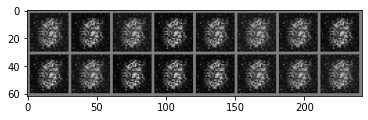

Avg Loss D=0.293982, Avg Loss G=3.698577


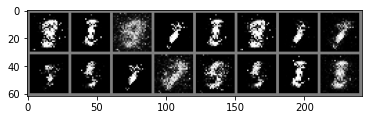

Avg Loss D=0.566572, Avg Loss G=2.328059


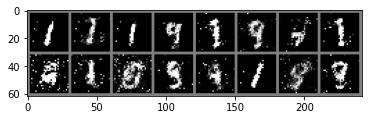

KeyboardInterrupt: ignored

In [9]:
if(__name__=="__main__"):

    root_dir = "/gdrive/My Drive/colab/gan/mnist"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"model_name":"epoch_{0:d}.pt".format(10),
              "root_dir":root_dir,
              "output_dir":output_dir,
              "d_input_node":784,#28*28
              "d_hidden_node":256,
              "d_output_node":1, #0 or 1
              "g_input_node":100, #28*28보다 작아야됨
              "g_hidden_node":256,
              "g_output_node":784,#28*28
              "learn_rate":0.0002,
              "batch_size":100,
              "epoch":100,
              }

    train(config)